In [1]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
input_img = Input(shape=(256, 256, 3))

l1 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(input_img)
l2 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l1)
l3 = MaxPooling2D(padding='same')(l2)
l3 = Dropout(0.3)(l3)
l4 = Conv2D(128, (3, 3),  padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l3)
l5 = Conv2D(128, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l4)
l6 = MaxPooling2D(padding='same')(l5)
l7 = Conv2D(256, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l6)
encoder = Model(input_img, l7)

In [3]:
encoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 128)    

In [4]:
l8 = UpSampling2D()(l7)

l9 = Conv2D(128, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l8)
l10 = Conv2D(128, (3, 3), padding='same', activation='relu',
             activity_regularizer=regularizers.l1(10e-10))(l9)

l11 = add([l5, l10])
l12 = UpSampling2D()(l11)
l13 = Conv2D(64, (3, 3), padding='same', activation='relu',
             activity_regularizer=regularizers.l1(10e-10))(l12)
l14 = Conv2D(64, (3, 3), padding='same', activation='relu',
             activity_regularizer=regularizers.l1(10e-10))(l13)

l15 = add([l14, l2])

# chan = 3, for RGB
decoded = Conv2D(3, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l15)

# Create our network
autoencoder = Model(input_img, decoded)
# You'll understand later what this is
autoencoder_hfenn = Model(input_img, decoded)

In [5]:
autoencoder.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
_______________________________________________________________________________________

In [6]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [7]:
from os import listdir
from matplotlib import image
from skimage.transform import resize, rescale
import cv2
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import numpy as np

In [8]:
filename="0001.png"
img_data = image.imread('/content/drive/My Drive/DIV2K_train_HR/' + filename)
image_resized = resize(img_data, (256, 256))

In [9]:
from skimage import img_as_ubyte

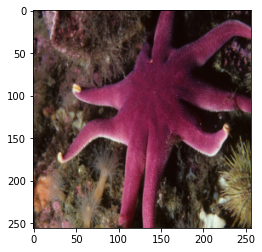

In [10]:
plt.imshow(image_resized)

In [11]:
scale_percent = 50
src=image_resized
width = int(src.shape[1] * scale_percent / 100)
height = int(src.shape[0] * scale_percent / 100)

In [12]:
dsize = (width, height)

In [13]:
output = cv2.resize(src, dsize)

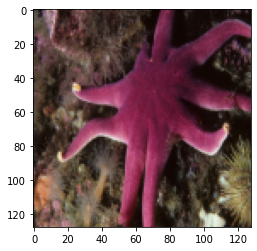

In [14]:
plt.imshow(output)

In [15]:
rescaled=cv2.resize(output, (256,256))

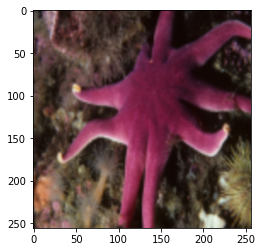

In [16]:
plt.imshow(rescaled)

In [17]:
import random
def shuffle(samples):
    shuffled=random.sample(samples, len(samples))  
    return shuffled

In [18]:
samples=[]
for filename in listdir('/content/drive/My Drive/DIV2K_train_HR'):
  samples.append(filename)
  print(filename +" Name uploaded to Samples")

0339.png Name uploaded to Samples
0338.png Name uploaded to Samples
0344.png Name uploaded to Samples
0337.png Name uploaded to Samples
0345.png Name uploaded to Samples
0347.png Name uploaded to Samples
0351.png Name uploaded to Samples
0348.png Name uploaded to Samples
0349.png Name uploaded to Samples
0346.png Name uploaded to Samples
0352.png Name uploaded to Samples
0350.png Name uploaded to Samples
0353.png Name uploaded to Samples
0360.png Name uploaded to Samples
0357.png Name uploaded to Samples
0358.png Name uploaded to Samples
0356.png Name uploaded to Samples
0359.png Name uploaded to Samples
0355.png Name uploaded to Samples
0354.png Name uploaded to Samples
0369.png Name uploaded to Samples
0365.png Name uploaded to Samples
0367.png Name uploaded to Samples
0371.png Name uploaded to Samples
0361.png Name uploaded to Samples
0364.png Name uploaded to Samples
0366.png Name uploaded to Samples
0372.png Name uploaded to Samples
0363.png Name uploaded to Samples
0370.png Name 

In [19]:
def generator(samples,batch_size=10):
    num_samples = len(samples)
    while True:
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            X_train = []
            y_train = []
            for sample_file in batch_samples:
                img_data = image.imread('/content/drive/My Drive/DIV2K_train_HR/'+sample_file)
                image_resized = resize(img_data, (256, 256))
                output = cv2.resize(image_resized, dsize)
                lr=cv2.resize(output, (256,256))
                X_train.append(img_as_ubyte(lr))
                y_train.append(img_as_ubyte(image_resized))
            X_train = np.array(X_train)
            y_train = np.array(y_train)
            yield X_train, y_train

In [20]:
train_datagen = generator(samples)

In [21]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("/content/drive/My Drive/IoTDemo/model_at_ep_{epoch:02d}.h5", monitor='loss', verbose=1, mode='auto', period=1)
callbacks_list = [checkpoint]

In [22]:
model=autoencoder.fit(train_datagen,epochs=20,steps_per_epoch=20,verbose=1,callbacks=callbacks_list)

Epoch 1/20
20/20 [==============================] - ETA: 0s - loss: 11791.4072
Epoch 00001: saving model to /content/drive/My Drive/IoTDemo/model_at_ep_01.h5
20/20 [==============================] - 95s 5s/step - loss: 11791.4072
Epoch 2/20
20/20 [==============================] - ETA: 0s - loss: 1270.9285 
Epoch 00002: saving model to /content/drive/My Drive/IoTDemo/model_at_ep_02.h5
20/20 [==============================] - 268s 13s/step - loss: 1270.9285
Epoch 3/20
20/20 [==============================] - ETA: 0s - loss: 417.3564 
Epoch 00003: saving model to /content/drive/My Drive/IoTDemo/model_at_ep_03.h5
20/20 [==============================] - 314s 16s/step - loss: 417.3564
Epoch 4/20
20/20 [==============================] - ETA: 0s - loss: 217.0178 
Epoch 00004: saving model to /content/drive/My Drive/IoTDemo/model_at_ep_04.h5
20/20 [==============================] - 293s 15s/step - loss: 217.0178
Epoch 5/20
20/20 [==============================] - ETA: 0s - loss: 163.0588
Epoc

In [23]:
print(model.history.keys())

dict_keys(['loss'])


Text(0.5, 0, 'epoch')

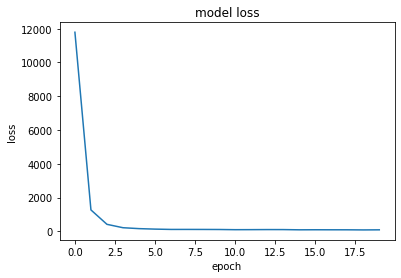

In [24]:
plt.plot(model.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

In [34]:
from keras.models import load_model
SuperRes=load_model('/content/drive/My Drive/IoTDemo/model_at_ep_20.h5')

In [35]:
SuperRes.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
_______________________________________________________________________________________

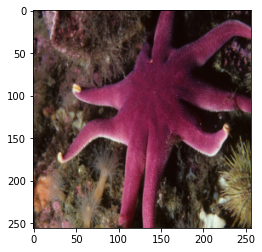

In [36]:
testimg="0001.png"
testimg_data = image.imread('/content/drive/My Drive/DIV2K_train_HR/' + testimg)
testimage_resized = resize(img_data, (256, 256))
plt.imshow(testimage_resized)

In [37]:
testscale_percent = 50
testsrc=testimage_resized
testwidth = int(testsrc.shape[1] * testscale_percent / 100)
testheight = int(testsrc.shape[0] * testscale_percent / 100)

In [38]:
testdsize = (testwidth, testheight)

In [39]:
testoutput = cv2.resize(testsrc, testdsize)

In [40]:
testrescaled=cv2.resize(testoutput, (256,256))

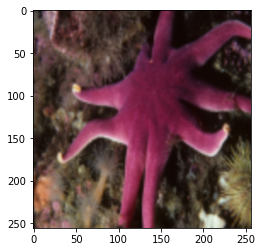

In [41]:
plt.imshow(testrescaled)

In [42]:
import tensorflow as tf
testimg=tf.expand_dims(testrescaled, axis=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


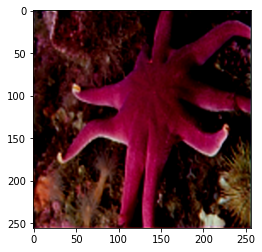

In [43]:
testsr=SuperRes.predict(testimg)
testout=tf.keras.backend.squeeze(testsr, axis=0)
plt.imshow(testout.numpy())